<h2>Работа с данными</h2>

In [1]:
import re
import time
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

<h3>1. Скачивание и обработка данных.</h3>

Скачивание нескольких датасетов из категории "Досуг" при помощи API request с сайта data.mos.ru

In [2]:
API_KEY = '109254e8cd834c79194bf0a58b457c2c'

In [3]:
# постобработка данных полученных с сайта mos.ru
def data_postprocess(response_data):
    temp = {
        'Name': response_data['Cells']['ObjectName'],
        'AdmArea': response_data['Cells']['AdmArea'],
        'District': response_data['Cells']['District'],
        'Address': response_data['Cells']['Address'],
        'HelpPhone': response_data['Cells']['HelpPhone'],
        'Latitude' : response_data['Cells']['geoData']['coordinates'][1],
        'Longitude' : response_data['Cells']['geoData']['coordinates'][0],
    }

    if 'NameSummer' in response_data['Cells'].keys():
        temp['NameSummer'] = response_data['Cells']['NameSummer']

    if 'WorkingHoursSummer' in response_data['Cells'].keys():
        for day_hour in response_data['Cells']['WorkingHoursSummer']:
            temp[day_hour['DayOfWeek']] = day_hour['Hours']
    elif 'WorkingHoursWinter' in response_data['Cells'].keys():
        for day_hour in response_data['Cells']['WorkingHoursWinter']:
            temp[day_hour['DayOfWeek']] = day_hour['Hours']
    elif 'WorkingHours' in response_data['Cells'].keys():
        for day_hour in response_data['Cells']['WorkingHours']:
            temp[day_hour['DayOfWeek']] = day_hour['Hours']

    return temp

# функция для скачивания датасета по его айди
# возвращает датафрейм
def get_dataset_API(dataset_name, dataset_id):
    url_count = "https://apidata.mos.ru/v1/datasets/" + str(dataset_id) + "/count"
    params_count = {
        'api_key': API_KEY
    }
    resp = requests.get(url=url_count, params=params_count)
    count = resp.text
    time.sleep(1)

    url_rows = "https://apidata.mos.ru/v1/datasets/" + str(dataset_id) + "/rows"
    dataset = []
    
    for i in range(0, int(count), 400):
        params = {
            'api_key': API_KEY,
            '$orderby': 'global_id',
            '$top': 400,
            '$skip': i
        }
        time.sleep(2)
        resp_rows = requests.get(url=url_rows, params=params)

        if (resp_rows.status_code == 200):
            data = resp_rows.json()
            dataset.extend([data_postprocess(row) for row in data if not isinstance(row, str)])
            
    df = pd.DataFrame(dataset)
    df.insert(loc=0, column='Id', value=range(1, len(df) + 1))
    df['Type'] = dataset_name
    return df


Места досуга и id датасета на сайте mos-data

In [4]:
leisure = {
    'autodrome_close' : 1384,
    'autodrome_open' : 1385,
    'pool_close' : 890,
    'pool_open' : 894,
    'tennis' : 60623,
    'train_gym' : 60624,
    'sport_gym' : 60622,
    'aquapark' : 2269,
}


Скачивание и сохранение данных в папку /data.

In [5]:
for key, val in leisure.items():
    df = get_dataset_API(key, val)
    df_name = key + '.csv'
    df.to_csv('./data/' + df_name)
    print(f"Dataset {df_name} created with length = {len(df)}")

Dataset autodrome_close.csv created with length = 10
Dataset autodrome_open.csv created with length = 18
Dataset pool_close.csv created with length = 404
Dataset pool_open.csv created with length = 19
Dataset tennis.csv created with length = 226
Dataset train_gym.csv created with length = 911
Dataset sport_gym.csv created with length = 3089
Dataset aquapark.csv created with length = 12


Объединим все датасеты в один

In [6]:
aquapark_df = pd.read_csv('./data/aquapark.csv', sep=',')
autodrome_close_df = pd.read_csv('./data/autodrome_close.csv', sep=',')
autodrome_open_df = pd.read_csv('./data/autodrome_open.csv', sep=',')
pool_close_df = pd.read_csv('./data/pool_close.csv', sep=',')
pool_open_df = pd.read_csv('./data/pool_open.csv', sep=',')
sport_gym_df = pd.read_csv('./data/sport_gym.csv', sep=',')
train_gym_df = pd.read_csv('./data/train_gym.csv', sep=',')
tennis_df = pd.read_csv('./data/tennis.csv', sep=',')
df_list = [aquapark_df, autodrome_close_df, autodrome_open_df, pool_close_df, pool_open_df, sport_gym_df, train_gym_df, tennis_df]

In [7]:
combined_df = pd.concat(df_list, ignore_index=True, sort=False)
combined_df.drop(columns=['Unnamed: 0'], inplace=True)
combined_df.drop(columns=['Id'], inplace=True)
len(combined_df)

4689

Заполнение пропусков

In [9]:
columns_to_fill = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
fill_values = {'понедельник': 'нет данных', 'вторник': 'нет данных', 'среда': 'нет данных', 
               'четверг': 'нет данных', 'пятница': 'нет данных', 'суббота': 'нет данных', 'воскресенье': 'нет данных'}
combined_df[columns_to_fill] = combined_df[columns_to_fill].fillna(fill_values)
combined_df['NameSummer'].fillna(combined_df['Name'], inplace=True)

In [10]:
combined_df.to_csv('./data/combined.csv')

In [12]:
combined_df.head()

,Name,AdmArea,District,Address,HelpPhone,Latitude,Longitude,NameSummer,понедельник,вторник,среда,четверг,пятница,суббота,воскресенье,Type
0,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Медленная река», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark
1,Аквапарк «Комплекс водных развлечений Мореон»,Юго-Западный административный округ,район Ясенево,"Голубинская улица, дом 16",(495) 374-53-35,55.597246,37.527184,волновой бассейн аквапарка Мореон,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,aquapark
2,Аквапарк «Центр семейного отдыха «Карибия»,Восточный административный округ,район Перово,"Зелёный проспект, дом 10Б",(495) 095-75-75,55.747844,37.778443,"главный бассейн плавательный в аквапарке №1, «...",10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,aquapark
3,Дворец водных видов спорта «Лужники»,Центральный административный округ,район Хамовники,"улица Лужники, дом 24, строение 4",(495) 637-03-60,55.712862,37.559213,"бассейн в аквапарке №1, «Медленная река»",07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,aquapark
4,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Буль-Буль», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark


<h3>2. Веб-скреппинг с помощью beautifulsoup.</h3>

2.1. Спарсим рейтинг мест досуга.

Добавим рейтинг для каждого заведения. Для этого создадим новую колонку Rating с дефолтным значением -1.

In [13]:
combined_df_rating = combined_df
combined_df_rating.insert(combined_df_rating.shape[1], 'Rating', -1)
combined_df_rating['Rating'] = combined_df_rating['Rating'].astype(float)
combined_df_rating['Address'] = combined_df_rating['Address'].apply(lambda x: (",").join(list(filter(lambda y: 'внутригородская территория муниципальный округ ' not in y, x.split(',')))))

In [14]:
combined_df_rating.head()

,Name,AdmArea,District,Address,HelpPhone,Latitude,Longitude,NameSummer,понедельник,вторник,среда,четверг,пятница,суббота,воскресенье,Type,Rating
0,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Медленная река», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,-1.0
1,Аквапарк «Комплекс водных развлечений Мореон»,Юго-Западный административный округ,район Ясенево,"Голубинская улица, дом 16",(495) 374-53-35,55.597246,37.527184,волновой бассейн аквапарка Мореон,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,aquapark,-1.0
2,Аквапарк «Центр семейного отдыха «Карибия»,Восточный административный округ,район Перово,"Зелёный проспект, дом 10Б",(495) 095-75-75,55.747844,37.778443,"главный бассейн плавательный в аквапарке №1, «...",10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,aquapark,-1.0
3,Дворец водных видов спорта «Лужники»,Центральный административный округ,район Хамовники,"улица Лужники, дом 24, строение 4",(495) 637-03-60,55.712862,37.559213,"бассейн в аквапарке №1, «Медленная река»",07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,aquapark,-1.0
4,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Буль-Буль», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,-1.0


Кидаем запросы гуглу с названием места и его адресом.
Далее парсим html ответ - ищем рейтинг места, если он есть. 

In [9]:
for idx, row in combined_df_rating.iterrows():
    place = row['Name'] + ' ' + row['Address']
    # add logs
    if idx % 100 == 0:
        print(idx, place)
    
    with requests.Session() as s:
        url = f"https://www.google.com/search?"
        headers = {
            "referer":"referer: https://www.google.com/",
            "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36",
        }
        params = {
            "q": place
        }

        response = s.get(url, headers=headers, params=params)
        soup = BeautifulSoup(response.text, 'html.parser')
        time.sleep(1.0)

    spans = soup.find_all("span", {"class": "Aq14fc"})

    if spans != []:
        rate = float(spans[0].text.replace(',','.'))
        print(f'Place idx = {idx} with rating = {rate}')
        combined_df_rating['Rating'][idx] = rate

0 Аквапарк «Фэнтази» Люблинская улица, дом 100
Place idx = 0 with rating = 4.1
Place idx = 1 with rating = 4.4
Place idx = 2 with rating = 4.5
Place idx = 3 with rating = 4.5
Place idx = 4 with rating = 4.1
Place idx = 5 with rating = 4.1
Place idx = 6 with rating = 4.5
Place idx = 7 with rating = 4.5
Place idx = 8 with rating = 4.5
Place idx = 9 with rating = 4.5
Place idx = 10 with rating = 4.5
Place idx = 11 with rating = 3.8
Place idx = 12 with rating = 4.7
Place idx = 13 with rating = 4.7
Place idx = 14 with rating = 4.6
Place idx = 15 with rating = 4.6
Place idx = 16 with rating = 4.6
Place idx = 17 with rating = 4.7
Place idx = 18 with rating = 4.3
Place idx = 22 with rating = 4.5
Place idx = 23 with rating = 4.5
Place idx = 24 with rating = 4.8
Place idx = 33 with rating = 4.6
Place idx = 38 with rating = 4.7
Place idx = 39 with rating = 4.4
Place idx = 41 with rating = 4.7
Place idx = 42 with rating = 4.5
Place idx = 43 with rating = 4.5
Place idx = 44 with rating = 4.5
Place 

In [17]:
combined_df_rating.head()

,Unnamed: 0,Name,AdmArea,District,Address,HelpPhone,Latitude,Longitude,NameSummer,понедельник,вторник,среда,четверг,пятница,суббота,воскресенье,Type,Rating
0,0,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Медленная река», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,4.1
1,1,Аквапарк «Комплекс водных развлечений Мореон»,Юго-Западный административный округ,район Ясенево,"Голубинская улица, дом 16",(495) 374-53-35,55.597246,37.527184,волновой бассейн аквапарка Мореон,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,aquapark,4.4
2,2,Аквапарк «Центр семейного отдыха «Карибия»,Восточный административный округ,район Перово,"Зелёный проспект, дом 10Б",(495) 095-75-75,55.747844,37.778443,"главный бассейн плавательный в аквапарке №1, «...",10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,aquapark,4.5
3,3,Дворец водных видов спорта «Лужники»,Центральный административный округ,район Хамовники,"улица Лужники, дом 24, строение 4",(495) 637-03-60,55.712862,37.559213,"бассейн в аквапарке №1, «Медленная река»",07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,aquapark,4.5
4,4,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Буль-Буль», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,4.1


Сохраним датасет с рейтингом в отдельный файл.

In [18]:
combined_df_rating.to_csv('./data/combined_rating.csv')

2.2. Спарсим количество оценок.
Для этого добавим колонку NumReviews с дефолтным значением -1.

In [19]:
combined_df_rating_counts = combined_df_rating
combined_df_rating_counts.insert(combined_df_rating_counts.shape[1], 'NumReviews', -1)
combined_df_rating_counts['NumReviews'] = combined_df_rating_counts['NumReviews'].astype(int)

In [20]:
combined_df_rating_counts.head()

,Unnamed: 0,Name,AdmArea,District,Address,HelpPhone,Latitude,Longitude,NameSummer,понедельник,вторник,среда,четверг,пятница,суббота,воскресенье,Type,Rating,NumReviews
0,0,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Медленная река», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,4.1,-1
1,1,Аквапарк «Комплекс водных развлечений Мореон»,Юго-Западный административный округ,район Ясенево,"Голубинская улица, дом 16",(495) 374-53-35,55.597246,37.527184,волновой бассейн аквапарка Мореон,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,aquapark,4.4,-1
2,2,Аквапарк «Центр семейного отдыха «Карибия»,Восточный административный округ,район Перово,"Зелёный проспект, дом 10Б",(495) 095-75-75,55.747844,37.778443,"главный бассейн плавательный в аквапарке №1, «...",10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,aquapark,4.5,-1
3,3,Дворец водных видов спорта «Лужники»,Центральный административный округ,район Хамовники,"улица Лужники, дом 24, строение 4",(495) 637-03-60,55.712862,37.559213,"бассейн в аквапарке №1, «Медленная река»",07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,aquapark,4.5,-1
4,4,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Буль-Буль», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,4.1,-1


Для парсинга количества оценок воспользуемся регулярным выражением. 

In [29]:
for idx, row in combined_df_rating_counts.iterrows():
    place = row['Name'] + ' ' + row['Address']
    # add logs
    if idx % 100 == 0:
        print(idx, place)
    
    with requests.Session() as s:
        url = f"https://www.google.com/search?"
        headers = {
            "referer":"referer: https://www.google.com/",
            "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36",
        }
        params = {
            "q": place
        }

        response = s.get(url, headers=headers, params=params)
        soup = BeautifulSoup(response.text, 'html.parser')
        time.sleep(1.0)

    spans = soup.find_all("span", {"class": "hqzQac"})
    if spans != []:
        text = str(spans[0])
        # используем регулярное выражение для нахождения кол-ва отзывов 
        pattern = r'<span>(\d+(?:\.\d+)?)\s+отзыв</span>'

        matches = re.findall(pattern, text)
        if matches:
            number_of_reviews = int(matches[0].replace('.', ''))
            print(f'Place idx = {idx} with num reviews = {number_of_reviews}')
            combined_df_rating_counts['NumReviews'][idx] = number_of_reviews
    

0 Аквапарк «Фэнтази» Люблинская улица, дом 100
Place idx = 0 with num reviews = 2317
Place idx = 1 with num reviews = 11995
Place idx = 2 with num reviews = 8347
Place idx = 3 with num reviews = 2758
Place idx = 4 with num reviews = 2317
Place idx = 5 with num reviews = 2317
Place idx = 6 with num reviews = 2758
Place idx = 7 with num reviews = 2758
Place idx = 8 with num reviews = 2758
Place idx = 9 with num reviews = 2758
Place idx = 10 with num reviews = 8347
Place idx = 11 with num reviews = 30
Place idx = 12 with num reviews = 112
Place idx = 13 with num reviews = 744
Place idx = 14 with num reviews = 403
Place idx = 15 with num reviews = 625
Place idx = 16 with num reviews = 470
Place idx = 17 with num reviews = 510
Place idx = 18 with num reviews = 5108
Place idx = 22 with num reviews = 398
Place idx = 23 with num reviews = 85
Place idx = 24 with num reviews = 6
Place idx = 33 with num reviews = 470
Place idx = 38 with num reviews = 198
Place idx = 39 with num reviews = 1477
Pla

In [23]:
combined_df_rating_counts.head()

,Unnamed: 0,Name,AdmArea,District,Address,HelpPhone,Latitude,Longitude,NameSummer,понедельник,вторник,среда,четверг,пятница,суббота,воскресенье,Type,Rating,NumReviews
0,0,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Медленная река», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,4.1,2317
1,1,Аквапарк «Комплекс водных развлечений Мореон»,Юго-Западный административный округ,район Ясенево,"Голубинская улица, дом 16",(495) 374-53-35,55.597246,37.527184,волновой бассейн аквапарка Мореон,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,09:00-23:00,aquapark,4.4,11995
2,2,Аквапарк «Центр семейного отдыха «Карибия»,Восточный административный округ,район Перово,"Зелёный проспект, дом 10Б",(495) 095-75-75,55.747844,37.778443,"главный бассейн плавательный в аквапарке №1, «...",10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,10:00-22:00,aquapark,4.5,8347
3,3,Дворец водных видов спорта «Лужники»,Центральный административный округ,район Хамовники,"улица Лужники, дом 24, строение 4",(495) 637-03-60,55.712862,37.559213,"бассейн в аквапарке №1, «Медленная река»",07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,07:00-22:00,aquapark,4.5,2758
4,4,Аквапарк «Фэнтази»,Юго-Восточный административный округ,район Марьино,"Люблинская улица, дом 100",(495) 641-34-51,55.654630,37.739043,"бассейн «Буль-Буль», в аквапарке Фэнтази",11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,11:00-23:00,aquapark,4.1,2317


In [22]:
combined_df_rating_counts.to_csv('./data/combined_rating_counts.csv')

<h3>3. Парсинг wiki сайта со статистиской округов Москвы.</h3>

Для более детального анализа не хватает данных по округам города Москва (площадь, население). Спарсим эти данные с вики.

In [24]:
wiki = "https://ru.wikipedia.org/wiki/%D0%90%D0%B4%D0%BC%D0%B8%D0%BD%D0%B8%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%82%D0%B5%D1%80%D1%80%D0%B8%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B"
response = requests.get(wiki)
print(response.status_code)

# парсим при помощи bs4
soup = BeautifulSoup(response.text, 'html.parser')
wiki_html = soup.find('table',{'class':"standard"})
links_a = wiki_html.findAll('a')
post_links = []
for link in links_a:
    if 'title' in link.attrs:
        post_links.append(link.text)

# сохраняем данные в отдельную таблицу
df_area = pd.DataFrame()
df_area['Округ'] = post_links

200


In [25]:
rows = wiki_html.findAll("tr")
wiki_data = []
header = [th.text.rstrip() for th in rows[0].find_all('th')][1:]

for row in rows[1:]:
    data = [d.text.rstrip() for d in row.find_all('td')]
    wiki_data.append(data)

df_temp = []
for row in rows[1:]:
    data = [d.text.rstrip() for d in row.select('td')]
    df_temp.append(data)

df_temp = pd.DataFrame(df_temp, columns=header)
df_copy = df_temp.copy()
df_copy.head(13)

df_copy = df_copy[:-1]
moscow_areas = pd.concat([df_area, df_copy], axis=1)
moscow_areas

,Округ,Площадь км²1.07.2012[6][7],% отобщейплощади,Местопоплощади,Населениечел. 2023 год[8],% отобщегонаселения,Место понаселению,Плотностьнаселениячел. / км²2023,Место поплотностинаселения
0,Центральный,"66,18","2,62 %",11,↘771 733[8],5.89,9,"11 661,91",5
1,Северный,"113,73","4,50 %",7,↗1 208 839[8],9.22,7,"10 629,4",7
2,Северо-Восточный,"101,88","4,03 %",9,↗1 438 138[8],10.97,4,"14 115,58",1
3,Восточный,"154,84","6,13 %",3,↘1 509 702[8],11.52,2,"9750,36",8
4,Юго-Восточный,"117,56","4,65 %",6,↗1 505 836[8],11.49,5,"12 809,12",4
5,Южный,"131,77","5,22 %",5,↘1 784 570[8],13.62,1,"13 542,77",2
6,Юго-Западный,"111,36","4,41 %",8,↗1 432 679[8],10.93,3,"12 865,04",3
7,Западный,"153,03","6,06 %",4,↘1 436 899[8],10.97,6,"9389,39",9
8,Северо-Западный,"93,28","3,69 %",10,↗1 032 775[8],7.88,8,"11 071,65",6
9,Зеленоградский,"37,20","1,47 %",12,↗262 505[8],2,11,"7056,6",10


In [27]:
moscow_areas.to_csv('./data/moscow_areas.csv')

In [30]:
# удалим лишние ссылки (квадратные скобки с цифрой и символы)
moscow_areas = pd.read_csv('./data/moscow_areas.csv')
# dоспользуемся регулярными выражениями для удаления ссылок
moscow_areas = moscow_areas.applymap(lambda x: re.sub(r'\[\d+\]', '', str(x)))
moscow_areas = moscow_areas.replace({'↘': '', '↗': ''}, regex=True)
moscow_areas.columns = moscow_areas.columns.map(lambda x: re.sub(r'\[\d+\]', '', str(x)))
moscow_areas.head()

,Unnamed: 0,Округ,Площадь км²1.07.2012,% отобщейплощади,Местопоплощади,Населениечел. 2023 год,% отобщегонаселения,Место понаселению,Плотностьнаселениячел. / км²2023,Место поплотностинаселения
0,0,Центральный,"66,18","2,62 %",11,771 733,5.89,9,"11 661,91",5
1,1,Северный,"113,73","4,50 %",7,1 208 839,9.22,7,"10 629,4",7
2,2,Северо-Восточный,"101,88","4,03 %",9,1 438 138,10.97,4,"14 115,58",1
3,3,Восточный,"154,84","6,13 %",3,1 509 702,11.52,2,"9750,36",8
4,4,Юго-Восточный,"117,56","4,65 %",6,1 505 836,11.49,5,"12 809,12",4


In [31]:
moscow_areas.to_csv('./data/moscow_areas.csv')

<h3>4. Проанализируем основные хар-ки итогового датасета.</h3>

4.1. Подсчет количества записей по каждому типу

In [32]:
dataset = pd.read_csv('./data/combined_rating_counts.csv')
count_by_type = dataset['Type'].value_counts()
print(count_by_type)

sport_gym          3090
train_gym           910
pool_close          405
tennis              224
autodrome_open       15
aquapark             12
autodrome_close      10
pool_open             9
Name: Type, dtype: int64


Отобразим значения при помощи круговой диаграммы.

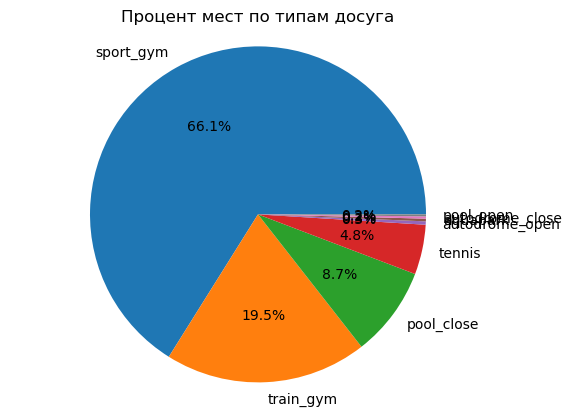

In [33]:
count_by_type = dataset['Type'].value_counts()

# Построение круговой диаграммы процента мест по типам досуга
plt.pie(count_by_type, labels=count_by_type.index, autopct='%1.1f%%')
plt.title('Процент мест по типам досуга')
plt.axis('equal')
plt.show()

4.2. Построение сводной таблицы с процентным соотношением от общего числа мест.

In [34]:
pivot_table = pd.pivot_table(dataset, index='Type', values='Name', aggfunc='count')
pivot_table['Percentage'] = pivot_table['Name'] / pivot_table['Name'].sum() * 100
print(pivot_table)

                 Name  Percentage
Type                             
aquapark           12    0.256684
autodrome_close    10    0.213904
autodrome_open     15    0.320856
pool_close        405    8.663102
pool_open           9    0.192513
sport_gym        3090   66.096257
tennis            224    4.791444
train_gym         910   19.465241


4.3. Построение сводной таблицы с процентным соотношением мест в зависимости от AdmArea

In [35]:
pivot_table = pd.pivot_table(dataset, index='AdmArea', values='Name', aggfunc='count')
pivot_table['Percentage'] = pivot_table['Name'] / pivot_table['Name'].sum() * 100

print(pivot_table)

                                         Name  Percentage
AdmArea                                                  
Восточный административный округ          509   10.887701
Западный административный округ           562   12.021390
Зеленоградский административный округ     114    2.438503
Новомосковский административный округ     176    3.764706
Северный административный округ           526   11.251337
Северо-Восточный административный округ   463    9.903743
Северо-Западный административный округ    309    6.609626
Троицкий административный округ            43    0.919786
Центральный административный округ        587   12.556150
Юго-Восточный административный округ      426    9.112299
Юго-Западный административный округ       463    9.903743
Южный административный округ              497   10.631016


4.4. Расчет среднего рейтинга мест для каждого типа досуга.

In [36]:
# фильтрация записей с рейтингом -1.0 или количеством отзывов -1
filtered_dataset = dataset[(dataset['Rating'] != -1.0) & (dataset['NumReviews'] != -1)]
mean_ratings = filtered_dataset.groupby('Type')['Rating'].mean()

print(mean_ratings)

Type
aquapark           4.333333
autodrome_close    4.600000
autodrome_open     4.600000
pool_close         4.399301
pool_open          4.628571
sport_gym          4.493961
tennis             4.557937
train_gym          4.438049
Name: Rating, dtype: float64


Построение гистограммы распределения рейтингов.

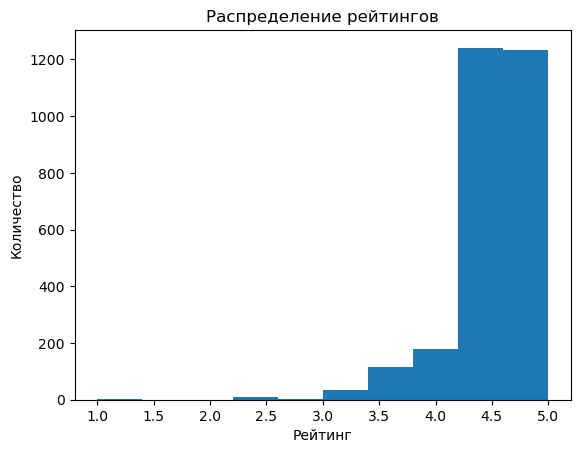

In [37]:
# фильтрация записей с рейтингом -1.0
filtered_dataset = dataset[dataset['Rating'] != -1.0]

plt.hist(filtered_dataset['Rating'], bins=10)
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.title('Распределение рейтингов')
plt.show()

4.5. Построение графика среднего рейтинга для каждого типа досуга.

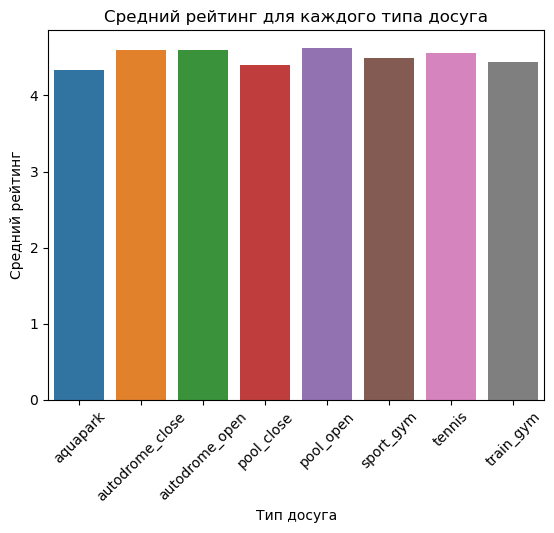

In [38]:
# фильтрация записей с рейтингом -1.0 или количеством отзывов -1
filtered_dataset = dataset[(dataset['Rating'] != -1.0) & (dataset['NumReviews'] != -1)]
# расчет среднего рейтинга для каждого типа досуга
mean_ratings = filtered_dataset.groupby('Type')['Rating'].mean().reset_index()

sns.barplot(x='Type', y='Rating', data=mean_ratings)
plt.xlabel('Тип досуга')
plt.ylabel('Средний рейтинг')
plt.title('Средний рейтинг для каждого типа досуга')
plt.xticks(rotation=45)
plt.show()

Остальная работа по датасету в файле leisure_streamlit.py